## Introduction to word2vec assignment

This assignment is an exploration of some of the information embodied in **continuous word embeddings**.  We wil work with high-quality pretrained vectors, so none of this work will touch on the concepts involved in training word embeddings, which have been covered in lecture.   For a visualization of word2vec training (including loss computations) have a look at this [cornell cs course animatioon](https://www.cs.cornell.edu/courses/cs4782/2026sp/demos/word2vec/) of training a toy corpus.

This notebook assumes you have Radim Rehurek's `gensim` module installed.
The notebook is self-contained and does not require prior knowledge of `gensim`, but if you do become
intereste din some of the capabilities gensim offers, see [Rehurek's tutorials page.](https://radimrehurek.com/gensim/auto_examples/index.html#documentation) for some helpful tutorials.

The cell below does the required installation, which works in Google Colab.

In [ ]:
!pip install gensim

##  Loading pretrained vectors

Load a high-quality set of word vectors.  Loading the vectors will take about 10 minutes in Google Colab.  The size of the word vector set is nearly 1 GB.

The training methods are described here:

```
@inproceedings{mikolov2018advances,
  title=    {Advances in Pre-Training Distributed Word Representations},
  author=   {Mikolov, Tomas and Grave, Edouard and Bojanowski, Piotr and Puhrsch, 
               Christian and Joulin, Armand},
  booktitle={Proceedings of the International Conference on Language Resources and Evaluation (LREC 2018)},
  year=     {2018}
}
```

The vectors about to be loaded are called **fasttext** vectors.  They contain subword information, which means the vectors encode information about the character sequences their words are spelled with.  This will affect some of the behaviors you observe, since it gives words with similar spellings (e.g., singular and plural nouns) more similar word vectors.

The gensim description of the gensim-maintained version, including size info.

In [580]:
# 1  GB
import gensim
import gensim.downloader as api

wordset = 'fasttext-wiki-news-subwords-300'
for (k,v) in api.info(wordset).items():
    print(f"{k:<30} {v}")

num_records                    999999
file_size                      1005007116
base_dataset                   Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens)
reader_code                    https://github.com/RaRe-Technologies/gensim-data/releases/download/fasttext-wiki-news-subwords-300/__init__.py
license                        https://creativecommons.org/licenses/by-sa/3.0/
parameters                     {'dimension': 300}
description                    1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens).
read_more                      ['https://fasttext.cc/docs/en/english-vectors.html', 'https://arxiv.org/abs/1712.09405', 'https://arxiv.org/abs/1607.01759']
checksum                       de2bb3a20c46ce65c9c131e1ad9a77af
file_name                      fasttext-wiki-news-subwords-300.gz
parts                          1


##  Loading the vectors with the gensim downloader

Pretty much every body should do this the first time, whether working on google colab or on your home achine.

Load the vectors with the gensim downloader (next code cell).  This is your **only** option in Google colab; On home or on Google, loading the vectors will take approximately 10 minutes, give or take.  If you execute the next cell on your home machine, gensim will place the vectors in your home directory under `gensim-data`. There is a progress bar telling you what percent of the vector file has been loaded, but note that when it completes, there are still several minutes of computing time remaining.

In [4]:
fast_vectors = api.load(wordset)
model2 = fast_vectors
model2

Execute this to confirm the vectors are there:

In [126]:
##  a vocab of 999,999  vector dimensionality 300
wvecs = model2.vectors
wvecs.shape

(999999, 300)

##  Loading the vectors from your local file system

The following cell should be edited if you have downloaded a version of the vectors onto your local file system, for example using the gensim downloader.  We will refer to the directory where  you place the vectors as `data_dir` and the full path as `text_path`.

All the local file system options below assume you have downloaded a full set of 1 illion word vec word vectors 
into `data_dir` on your home machine,.  These are available on [wvec download page](https://fasttext.cc/docs/en/english-vectors.html) as 
**wiki-news-300d-1M-subword.vec.zip**, you don't want to use the gensim downloader.

You will need to unzip them for everything below to work.

In [762]:
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
import os.path
data_dir = '/Users/gawron/gensim-data/fasttext-wiki-news-subwords-300'
fn = 'fasttext-wiki-news-subwords-300'
# Path for text version  of the full vector model (the default path)
# Save the unzipped downloaded vectors here
text_path = os.path.join(data_dir,fn)

truncated_stem = "_100K_vocab"
# Use truncated vectors (100K words) after the first time
truncate = True
truncated_text_path = text_path + truncated_stem

## Only one or neither of the next two flags shd be true
## Decide what version of the vectors you want to save first
save_text_vecs = False
save_binary_vecs = False

if truncate:
    binary_path = text_path + truncated_stem + ".bin"
else:
    ## save untruncated binary vecs
    binary_path = text_path + ".bin"

**Local Option 1**: Load the full set of vectors from the model file you have saved on your disk.   Then you would do

```python
wv_from_text = KeyedVectors.load_word2vec_format(text_path, binary=False) 
```

from this notebook.  This is generally **not** the option you would take your first time through.  You would save the vecs locally with a gensim download first.  Then the second time do this.

**Local Option 2a**:  Load a **truncated** subset (top 100K) of the vectors from the **full model** file (1 million vectors).

Everything in this notebook will work fine with the truncated vocab, except  that your scores on the analogy task will be slightly lower because of 31 missing somewhat rare words. 

If you want reclaim some disk space, you can load the vectors from `text_path` as in the next cell, then turn around and save the vectors to `truncated_text_path` using `wv_from_text.save_word2vec_format` (illustrated in the comments). You can then delete the much larger `text_path` file from your hard drive.

In [747]:
# adding limit = 100_000 argument to load only the 100K most frequent words from the 1 GB file
wv_from_text = KeyedVectors.load_word2vec_format(text_path, limit=100_000, binary=False)  # C text format
###############################################################
if truncate and save_text_vecs:
   ## save truncated text vecs
   wv_from_text.save_word2vec_format(truncated_text_path,binary=False)
###############################################################

**Local Option 2b:**   You have saved binary vectors (truncated or not, as illustrated in next cell) in some previous session.

In [763]:
# Save vecs in binary format for faster loading next time.
# Have added 31 new vocab items to the original 100K vocab (for analogy test set coverage)
# by working with a full vocab and using code later in the NB

if save_binary_vecs:
    wv_from_text.save_word2vec_format(binary_path,binary=True)

Now, **if they have been made available**,  we load that binary version (very fast) as follows:

In [756]:
wv_from_text = KeyedVectors.load_word2vec_format(binary_path, binary=True)  # C text format

###  A look at the vocab

In [687]:
tlws = [k for k in wv_from_text.key_to_index if len(k)==3]

In [688]:
'ion' in tlws, 'the' in tlws, 'and' in tlws, 'ham' in tlws, 'dog' in tlws

(True, True, True, True, True)

In [690]:
print(len(tlws))
print(tlws[-50:])

7276
['GfK', 'KCC', 'мне', 'dur', 'oni', 'IOU', 'MIG', 'FGS', 'TER', 'EOP', 'SCL', 'bks', 'acc', 'PCH', 'leq', 'FMF', 'SPG', 'UWS', 'mei', 'NIJ', '30C', '90m', 'Al-', 'GTL', 'CBW', 'Abs', 'MVA', 'LCM', 'VfL', 'GPT', 'AGU', 'LPR', 'ona', 'hal', 'mem', 'SFM', 'CHE', "'al", 'N2O', 'SDO', 'DFO', 'Boz', 'GSN', 'IIs', 'كان', 'Mex', 'Sap', 'GCR', 'leu', 'lev']


In [754]:
#dir(wv_from_text)
wv_from_text.vectors[100_030,:20]

array([-0.011599 , -0.035565 ,  0.020809 ,  0.022919 ,  0.03974  ,
       -0.010865 , -0.0029827, -0.13795  , -0.02587  ,  0.0027815,
       -0.0091551,  0.050798 , -0.0075865, -0.044718 ,  0.027331 ,
        0.033138 ,  0.062173 , -0.10651  ,  0.050687 , -0.038793 ],
      dtype=float32)

Fetch a word vector and examine its first 30 components:

In [128]:
model2["woman"][:30]

array([-0.089032 ,  0.0070157,  0.043966 ,  0.0095868, -0.0065863,
        0.021975 ,  0.03802  , -0.11633  ,  0.086124 ,  0.043658 ,
        0.068408 ,  0.016394 ,  0.044093 ,  0.0015541, -0.11214  ,
       -0.014895 ,  0.044228 , -0.084028 ,  0.017321 ,  0.035936 ,
       -0.020162 , -0.0071014, -0.069285 ,  0.081374 , -0.0078895,
       -0.026504 ,  0.048517 ,  0.083375 ,  0.022454 , -0.044504 ],
      dtype=float32)

## A high-frequency smaller vocabulary

Set up a small vocabulary of the 5K or so most frequent words.  This is **Optional**.  It is only essential if you want to write code to answer some of the questions below.  Answering those questions will involve search; nearest neighbor calculations while searching through the V vocabulary words will make your time quadratic on V, so creating a search space of 5K words instead of 100K (or even 1,000,000 words) is then important.

In [12]:
import pandas as pd

def find_good_model_words (model,words=None,url=None):
    """
    Use Frequency sorted BNC word list to get a list of frequent (well-modeled words)
    and winnow it down to those we have vectors for.
    """
    if url is None:
        url = "https://www.kilgarriff.co.uk/BNClists/lemma.num"
    df = pd.read_csv(url,sep = " ",header=None,index_col=None,names=("rank freq word pos".split()))
    words = df["word"].values
    res = []
    for wd in words:
        if wd in res:
            continue
        else:
            res.append(wd)
    words = res
    search_wds = [wd for wd in words if wd in model.key_to_index]
    search_space = [model[wd] for wd in words if wd in search_wds]
    print(f"{len(search_wds)} found")
    return search_wds, search_space, words

# First time in executing this cell provide value None
words = None
search_wds,search_space,words = find_good_model_words(model2,words,url="lemma.num.txt")

5464 found


## Basic word similarities

#### hs = 0

In [691]:
model2.similarity('woman', 'girl')

0.75772464

In [692]:
model2.similarity('woman', 'boy')

0.62647694

In [693]:
model2.similarity('man', 'boy')

0.67477584

In [694]:
model2.similarity('man', 'girl')

0.6418483

In [695]:
model2.similarity('boy', 'girl')

0.8773635

In [696]:
model2.similarity('man', 'woman')

0.8119809

## Visualizing the word vectors

Reduce dimensionality to 2 (in 2 steps, as per recommendation of `sklearn` docs for using `tsne`).

In [697]:
import sklearn
from sklearn import decomposition, manifold
import numpy as np

#search_wds,search_space
search_space = np.array(search_space)
## PCA reduction
red1 = decomposition.PCA(n_components=25)
print("Doing PCA reduction")
search_space2 = red1.fit_transform(search_space)
print("PCA reduction done")

# TSNE reduction
print("Doing TSNE reduction")
red2 = manifold.TSNE(n_components=2)
print("TSNE reduction done")
search_space3 = red2.fit_transform(search_space2)
#(5464, 2)
print(f"Final data shape: {search_space3.shape}")

Doing PCA reduction
PCA reduction done
Doing TSNE reduction
TSNE reduction done
Final data shape: (5464, 2)


Plot the reduced vectors:

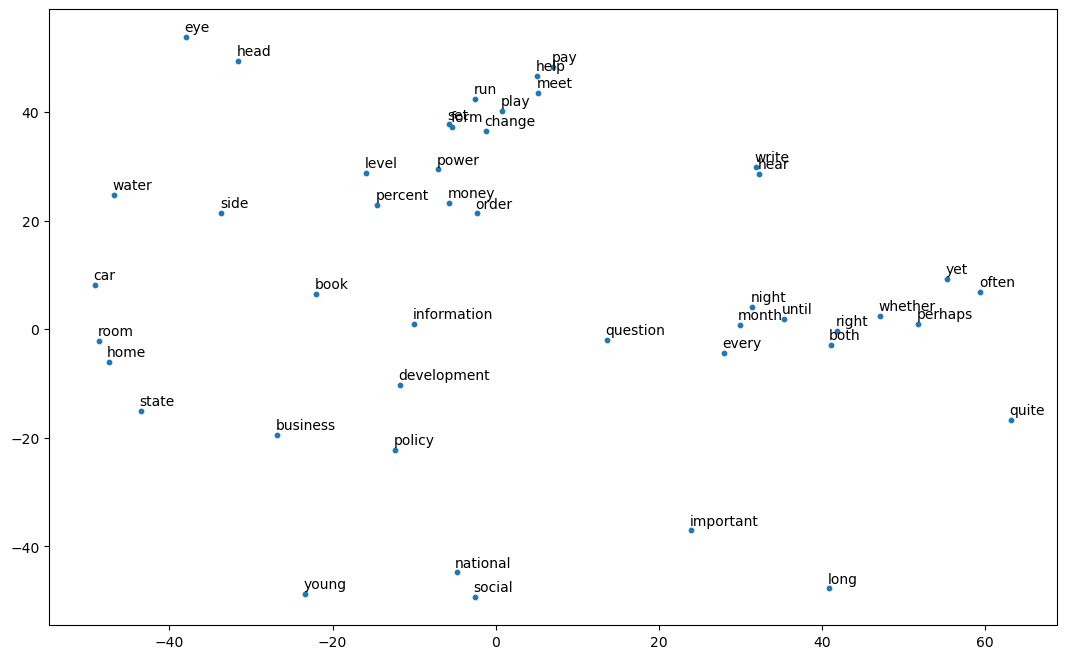

In [698]:
from matplotlib import pyplot as plt

N = 50
start = 200
word_samp = search_wds[start:start+N]
#word_samp = [wd for wd in word_samp if wd not in {"start","though","include","interest"}]
red_vecs_samp = search_space3[start:start+N]
samp = [(wd, red_vecs_samp[i,0],red_vecs_samp[i,1]) for (i,wd) in enumerate(word_samp) \
            if wd not in {"start","though","include","interest","move"}]
#x,y = red_vecs_samp[:,0],red_vecs_samp[:,1]


(fig,ax) = plt.subplots(figsize=(13,8))
wds,xs,ys = zip(*samp)
plt.scatter(xs,ys,s=10)

for (wd,x,y) in samp:
    #print(wd)
    plt.annotate(wd, xy=(x,y), xytext=(-1,4), textcoords="offset points")

## Nearest neighbors

Nearest neighbor list for *woman* unrestricted vocabulary.  Some rare words show up, although they still make sense:

In [699]:
model2.most_similar(positive=['woman'],topn=10)

[('man', 0.8119807243347168),
 ('woman--', 0.7959198951721191),
 ('lady', 0.7750157117843628),
 ('girl', 0.7577246427536011),
 ('woman-', 0.7568190097808838),
 ('womans', 0.7453511953353882),
 ('women', 0.7260429859161377),
 ('child-woman', 0.7223398089408875),
 ('trans-woman', 0.7164039015769958),
 ('woman-child', 0.7128437161445618)]

Nearest neighbor list for `woman` with restricted vocabulary. Not always a good idea to restrict the vocab, but it sometimes helps:

In [700]:
model2.most_similar(positive=['woman'],topn=10,restrict_vocab=10_000)

[('man', 0.8119807243347168),
 ('lady', 0.7750157117843628),
 ('girl', 0.7577246427536011),
 ('women', 0.7260429859161377),
 ('female', 0.7014045715332031),
 ('husband', 0.6878941655158997),
 ('person', 0.6830306649208069),
 ('mother', 0.6769816875457764),
 ('wife', 0.6661549806594849),
 ('male', 0.6632648706436157)]

In [701]:
model2.most_similar(positive=['computer'],topn=10,restrict_vocab=10_000)

[('computers', 0.8472652435302734),
 ('software', 0.7308359146118164),
 ('computing', 0.7130760550498962),
 ('laptop', 0.6961240172386169),
 ('machine', 0.6935686469078064),
 ('hardware', 0.6780312061309814),
 ('electronics', 0.663975179195404),
 ('technology', 0.6604807376861572),
 ('desktop', 0.6521348357200623),
 ('Computer', 0.6456718444824219)]

In [702]:
model2.most_similar(positive=['computer'],topn=10,restrict_vocab=5_000)

[('computers', 0.8472652435302734),
 ('software', 0.7308359146118164),
 ('machine', 0.6935686469078064),
 ('hardware', 0.6780312061309814),
 ('technology', 0.6604807376861572),
 ('internet', 0.6444270610809326),
 ('electronic', 0.6268055438995361),
 ('PC', 0.6184285283088684),
 ('machines', 0.6025169491767883),
 ('digital', 0.5929277539253235)]

In [703]:
model2.most_similar(positive=['twitter'],topn=10,restrict_vocab=10_000)
#[(wd,sc) for (wd,sc) in model2.most_similar(positive=['twitter'],topn=100,restrict_vocab=10_000) 
#    if "twitt" not in wd.lower()]

[('Twitter', 0.8208357095718384),
 ('Facebook', 0.6506764888763428),
 ('blog', 0.5960510969161987),
 ('blogs', 0.5761139988899231),
 ('YouTube', 0.5179937481880188),
 ('chat', 0.4908485412597656),
 ('news', 0.4890054166316986),
 ('web', 0.47877150774002075),
 ('website', 0.47871994972229004),
 ('email', 0.47649359703063965)]

##  Closer than calculations

Along with the `most_similar` method, we have the `closer_than` method.

There aren't that many words/countries (semantically) closer to Brazil than Argentina, but there are some:

In [704]:
model2.closer_than("Brazil", "Argentina")

['Portugal', 'Brasil', 'Brazils', 'Brazilia', 'Brazil.', 'Brazil-']

More competition in the other direction.  Note the absence of *Spain*.

In [705]:
model2.closer_than("Argentina", "Brazil")

['Chile',
 'Uruguay',
 'Argentine',
 'Bolivia',
 'Paraguay',
 'Argentinas',
 'Argentinan',
 'Argentinia',
 'Argentina.',
 'Brazil-Argentina']

Not that many words/names closer to Freud than Marx:

In [706]:
model2.closer_than("Freud", "Marx")

['Nietzsche',
 'psychoanalysis',
 'Sigmund',
 'Freudian',
 'Lacan',
 'Psychoanalysis',
 'psychoanalysts',
 'Nietzche',
 'Freudians',
 'Freudianism',
 'Krafft-Ebing',
 'Fliess',
 'freud',
 'Freuds',
 'Freudenberger',
 'Stekel',
 'Freudiger',
 'Freudberg']

Short list.  One philosopher, and one of Plato's more famous works; interestingly Socrates is a main character.

In [765]:
model2.closer_than("Plato", "Socrates")

['Aristotle', 'Phaedo']

And really no cities closer to Cleveland than Cincinnati:

In [707]:
model2.closer_than("Cleveland", "Cincinnati")

['Clevelands']

#  Part One Questions

**Question 1:**  Find the 5 nearest neighbor of *gorilla* if the vocabulary is unrestricted:

**Solution**

In [708]:
model2.most_similar(positive=['gorilla'],topn=5)

[('gorillas', 0.8310797214508057),
 ('chimpanzee', 0.7090175151824951),
 ('chimp', 0.705582857131958),
 ('orangutan', 0.703140377998352),
 ('gorilla-like', 0.6914221048355103)]

**Question 2:**  The value of the `positive`-argument of `most_similar` can be a vector.
Average the vectors of *gorilla* and *man* and find the 5 nearest neighbors
to that average:

**Solution**

In [709]:
avg = (model2["man"] + model2["gorilla"])/2
model2.most_similar(positive=avg,topn=5)

[('man', 0.8808894157409668),
 ('gorilla', 0.8068998456001282),
 ('woman', 0.7249176502227783),
 ('apeman', 0.7201209664344788),
 ('man-ape', 0.7170995473861694)]

There is actually a method for doing this which accepts a set of vectors, which is fun to play with.

In [710]:
avg2 = model2.get_mean_vector(["gorilla","man"])
model2.most_similar(positive=avg2,topn=5)

[('gorilla', 0.8459325432777405),
 ('man', 0.8459324240684509),
 ('ape', 0.7206934094429016),
 ('apeman', 0.7174420952796936),
 ('man-ape', 0.7141361832618713)]

In [711]:
avg2 = model2.get_mean_vector(["blue","red"])
model2.most_similar(positive=avg2,topn=7)

[('red', 0.9782130122184753),
 ('blue', 0.9782128930091858),
 ('yellow', 0.8905166983604431),
 ('purple', 0.8573741912841797),
 ('pink', 0.8360656499862671),
 ('green', 0.8251579999923706),
 ('orange', 0.8056360483169556)]

In [712]:
avg2 = model2.get_mean_vector(["north","south","east","west"])
model2.most_similar(positive=avg2,topn=8)

[('north', 0.9780260920524597),
 ('south', 0.9730840921401978),
 ('west', 0.9711037278175354),
 ('east', 0.968540608882904),
 ('southeast', 0.8879513740539551),
 ('southwest', 0.8878387212753296),
 ('northeast', 0.8818960189819336),
 ('northwest', 0.876802921295166)]

**Question 3:** There is a strong tendency for the nearest neighbor of a noun to be its standard plural.  As an illustration of just how strong this tendency is, consider *deer*:

In [766]:
model2.most_similar(positive=["deer"],topn=5)

[('deers', 0.8134419322013855),
 ('elk', 0.7754461765289307),
 ('moose', 0.752448558807373),
 ('elks', 0.7269112467765808),
 ('deer-hunting', 0.7168375849723816)]

The word *deers* is unusual and not the standard plural of *deer*.  Yet it occurs often enough in the 16 Billion- token training data to earn a word vector. One reason for this strong tendency is that in the fasttext model we are using, spelling contributes to vector similarity.  Yet there are already examples you have seen in this notebook where the nearest neighbor of a noun is not its plural.  Find 5 examples of nouns whose nearest neighbors are not their standard plurals, and you can use examples in this notebook for some of the 5. Hint: the examples in this notebook have a linguistic property that will help you find more.

**Solution**  The linguistic property that helps (but is not necessary) is having irregular plurals, so that the plural form is not quite as close in spelling to the singular as regular plurals are.

In [714]:
model2.most_similar(positive=["man"],topn=10)

[('woman', 0.8119808435440063),
 ('man--', 0.732385516166687),
 ('man--and', 0.7230692505836487),
 ('person', 0.7203925848007202),
 ('mad-man', 0.7037577629089355),
 ('guy', 0.6992258429527283),
 ('god-man', 0.69350266456604),
 ('boy-man', 0.6925113797187805),
 ('man--the', 0.6904608607292175),
 ('man-love', 0.6874001622200012)]

In [715]:
model2.most_similar(positive=["woman"],topn=10)

[('man', 0.8119807243347168),
 ('woman--', 0.7959198951721191),
 ('lady', 0.7750157117843628),
 ('girl', 0.7577246427536011),
 ('woman-', 0.7568190097808838),
 ('womans', 0.7453511953353882),
 ('women', 0.7260429859161377),
 ('child-woman', 0.7223398089408875),
 ('trans-woman', 0.7164039015769958),
 ('woman-child', 0.7128437161445618)]

In [716]:
model2.most_similar(positive=["child"],topn=10)

[('non-child', 0.7806164622306824),
 ('boy-child', 0.7771493196487427),
 ('infant', 0.7692996859550476),
 ('mother', 0.7654839754104614),
 ('child--', 0.7639940977096558),
 ('children', 0.7630216479301453),
 ('childen', 0.7588273882865906),
 ('parent', 0.746644139289856),
 ('childʼs', 0.7437947392463684),
 ('only-child', 0.7417019605636597)]

This one is like deer, the regular plural form muscles its way in, even though it is far less frequent
than *mice*.

In [717]:
model2.most_similar(positive=["mouse"],topn=10)

[('mouses', 0.7705859541893005),
 ('mousing', 0.7554763555526733),
 ('mice', 0.7038449645042419),
 ('mouse-button', 0.7035195231437683),
 ('mouse-like', 0.6904830932617188),
 ('mousepad', 0.6862655878067017),
 ('mouse-click', 0.6830845475196838),
 ('mouse-based', 0.6790381669998169),
 ('mouse-clicking', 0.6651208996772766),
 ('moused', 0.6525858044624329)]

In [718]:
model2.most_similar(positive=["loaf"],topn=10)

[('bread', 0.7509481906890869),
 ('loafs', 0.7418695688247681),
 ('loaves', 0.659576416015625),
 ('butter', 0.6558520197868347),
 ('biscuit', 0.6432216763496399),
 ('baguette', 0.6394046545028687),
 ('scone', 0.6365483403205872),
 ('brioche', 0.635867714881897),
 ('wholemeal', 0.6191232800483704),
 ('meatloaf', 0.6027717590332031)]

In [719]:
model2.most_similar(positive=["axis"],topn=10)

[('X-axis', 0.7045288681983948),
 ('Z-axis', 0.7040368318557739),
 ('z-axis', 0.7037435173988342),
 ('axis.', 0.7013909220695496),
 ('x-axis', 0.698753833770752),
 ('semi-axis', 0.6924705505371094),
 ('y-axis', 0.6903954148292542),
 ('long-axis', 0.6799377202987671),
 ('-axis', 0.6764941215515137),
 ('cross-axis', 0.6733323931694031)]

In [720]:
model2.most_similar(positive=["crisis"],topn=10)

[('mini-crisis', 0.8113057613372803),
 ('crises', 0.8089130520820618),
 ('crisis-', 0.8034021854400635),
 ('non-crisis', 0.7960949540138245),
 ('near-crisis', 0.7668130397796631),
 ('postcrisis', 0.7658597230911255),
 ('debt-crisis', 0.7403367757797241),
 ('turmoil', 0.7358798980712891),
 ('crisis.', 0.7320274710655212),
 ('financial-crisis', 0.7316805720329285)]

**Question 4:**  The vectors for the nouns *cheap* and *inexpensive* are mutual nearest neighbors (NNs) in the sense that the *cheap* vector is the nearest neighbor of the *inexpensive* vector and the *inexpensive* vector is the nearest neighbor of the *cheap* vector, as shown below.  It doesn't have to work out that way (as an example, consider prime numbers: 19  is the closest prime to 23, but 23 is not the closest prime to 19; 17 is).  Come up with three more examples of mutual NNs. Avoid related words like  nouns and their plurals or *act* and *action*.  As a very rough rule for determining two words are unrelated, they shouldn't share their first three letters.  Demonstrate the fact that your word pairs are mutual NNs by finding each word's NN as we have done for *cheap* and *inexpensive* below.  Hint:  Follow the pattern of *cheap* and *inexpensive* and try common adjectives that are strongly associated.  If you need help knowing what an adjective is, look at  [Adam Kilgariff's BNC frequnecy sorted word list](https://www.kilgarriff.co.uk/BNClists/lemma.num), and look for words whose part-of-speech is "a". 

In [721]:
model2.most_similar(positive=["cheap"],topn=1), model2.most_similar(positive=["inexpensive"],topn=1)

([('inexpensive', 0.8434295654296875)], [('cheap', 0.8434293270111084)])

Note that many of the words that qualify **aren't** synonyms.  They're just
strongly associated words, for example, words that are often paired
in discourse.

**Solutions**:

In [722]:
model2.most_similar(positive=["man"],topn=1),model2.most_similar(positive=["woman"],topn=1)

([('woman', 0.8119808435440063)], [('man', 0.8119807243347168)])

In [723]:
model2.most_similar(positive=["short"],topn=1),model2.most_similar(positive=["long"],topn=1)

([('long', 0.7923822999000549)], [('short', 0.7923824787139893)])

In [724]:
model2.most_similar(positive=["white"],topn=1), model2.most_similar(positive=["black"],topn=1)

([('black', 0.9345934391021729)], [('white', 0.9345934987068176)])

In [725]:
model2.most_similar(positive=["bad"],topn=1),model2.most_similar(positive=["good"],topn=1)

([('good', 0.8503089547157288)], [('bad', 0.8503088355064392)])

In [726]:
model2.most_similar(positive=["excellent"],topn=1),model2.most_similar(positive=["superb"],topn=1)

([('superb', 0.8295968174934387)], [('excellent', 0.8295969367027283)])

In [727]:
model2.most_similar(positive=["dry"],topn=1),model2.most_similar(positive=["wet"],topn=1)

([('wet', 0.8566859364509583)], [('dry', 0.8566858768463135)])

**Question 4:**  Now find two unrelated words *a* and *b* such that *a* is the nearest neighbor of *b* but *b* is not the nearest neighbor of *a*, and whatever *b*'s nearest neighbor is, it isn't related to *b* (by the first three letters rule).    Demonstrate your answers by finding the nearest neighbors of *a* and *b* as in Question 3.  Option 1: you can code this up.  Use `search_wds` above to limit your search to a few thousand common words.  Or: Option 2 one place to look is in **sets** of strongly associated adjectives or adverbs, such as *fair, good, excellent* (except those don't work), *warm*, *lukewarm*, *cool* (and those don't work).

Of course,  word pairs that answer this question don't have to be adjectives.  One example of the kind of *a* and *b* words you're looking for is *aunt* and *uncle*.  Here's the demonstration.

In [438]:
model2.most_similar(positive=["aunt"],topn=1),model2.most_similar(positive=["uncle"],topn=1)

([('uncle', 0.8582535982131958)], [('nephew', 0.870086133480072)])

So what you'll end up with is a triplet of semantically close words.   In this case they're all 
common **kinship terms**.

**Solutions**

This one is my favorite, because it makes so much sense colorwise:

In [728]:
model2.most_similar(positive=["purple"],topn=1),model2.most_similar(positive=["blue"],topn=1)

([('blue', 0.8553687334060669)], [('red', 0.9138011932373047)])

Also of interest:

In [772]:
model2.most_similar(positive=["lukewarm"],topn=1),model2.most_similar(positive=["tepid"],topn=1)

([('tepid', 0.8382373452186584)], [('lukewarm', 0.8382373452186584)])

In [433]:
model2.most_similar(positive=["yellow"],topn=1),model2.most_similar(positive=["red"],topn=1)

([('red', 0.8753618001937866)], [('blue', 0.9138011932373047)])

In [434]:
model2.most_similar(positive=["local"],topn=1),model2.most_similar(positive=["regional"],topn=1)

([('regional', 0.8151846528053284)], [('national', 0.845012366771698)])

In [435]:
model2.most_similar(positive=["essential"],topn=1),model2.most_similar(positive=["vital"],topn=1)

([('vital', 0.8695250749588013)], [('crucial', 0.8794239163398743)])

In [436]:
model2.most_similar(positive=["afraid"],topn=1),model2.most_similar(positive=["scared"],topn=1)

([('scared', 0.7811442017555237)], [('frightened', 0.8641623258590698)])

In [437]:
model2.most_similar(positive=["exceptional"],topn=1),model2.most_similar(positive=["extraordinary"],topn=1)

([('extraordinary', 0.8303589820861816)], [('remarkable', 0.8590794205665588)])

**Coding up the last two problems**

Use the `search_wds` list computed above to stick to common words:

In [729]:
#search_wds,search_space
# Keeping the mutual nns in two aligned lists
partner_a,partner_b = [],[]
# This will be a list of triples
triplets = [ ]
for word_1 in search_wds:
    if len(word_1) <= 3:
        continue
    if word_1 in partner_b:
        #  this word is already in  a mutual nn couple
        continue
    nn_1 = model2.most_similar(positive=[word_1],topn=1)[0][0]
    if len(nn_1) <= 3 or nn_1 not in search_wds:
        continue
    if nn_1[:3] == word_1[:3]:
        # related word probably
        continue
    nn_2 = model2.most_similar(positive=[nn_1],topn=1)[0][0]
    if nn_2 == word_1:
        partner_a.append(word_1)
        partner_b.append(nn_1)
    elif nn_2[:3] == nn_1[:3]:
        # related word probably
        continue
    elif nn_2 not in search_wds:
        # stay away from rarer words
        continue
    else:
        triplets.append((word_1,nn_1,nn_2))
            

In [730]:
len(partner_a),len(partner_b)

(193, 193)

In [731]:
for (p1,p2) in zip(partner_a, partner_b):
    print(f"{p1:<25}  {p2:<25}")

would                      could                    
into                       onto                     
think                      believe                  
more                       less                     
last                       next                     
should                     must                     
these                      those                    
after                      before                   
something                  anything                 
small                      large                    
country                    nation                   
really                     actually                 
week                       month                    
word                       phrase                   
although                   though                   
example                    instance                 
long                       short                    
often                      frequently               
national                   regional           

In [732]:
len(triplets)

127

In [733]:
for (p1,p2,p3) in triplets:
    print(f"{p1:<25}  {p2:<25} {p3:<25}")

some                       many                      several                  
year                       month                     week                     
than                       less                      more                     
other                      various                   numerous                 
just                       simply                    merely                   
only                       just                      simply                   
very                       extremely                 incredibly               
such                       certain                   specific                 
even                       just                      simply                   
many                       several                   numerous                 
thing                      kind                      sort                     
back                       down                      up                       
still                      definitely               

**Question 6**:  Look up the 25 words most similar to *inteligence* and *lingusitics* (yes, those are  the spellings I mean), and describe an application of word vectors involving spelling correction.

**Solution**:  Maintain a  regular dictionary and morphological analyzer that works only with standard words.
When a lookup fails (presumably because of a misspelling), turn to your word vector model (`wv`) and look up the misspelling using `wv.most_similar`. Choose the nearest neighbor that is in the standard dictionary.  You might also want to check that it shares a lot of letters with the misspelling and move on to the next best candidate if not.

## Part Two:  The analogy test set

Demonstrating state-of-the-art performance on the analogy test set was an early triumph of the word2vec model.  Some of the inflated claims made as a result of that performance have been justifiably criticized since, on the grounds that there are many kinds of analogies that humans are good at that this kind of word vector model is very bad at.  In retrospect, however, the strong performance on analogies, in particular, the kind of analogies the system was best at, can be seen an early harbinger of the power of language models.

As you will see below, it demonstrates just how much real world knowwledge is packed into a robustly trained language model, forshadowing the spectular successes of later LLMs on tasks like question-answering.

## Completing an analogy


The task for the system is to complete an analogy of the following form :  *Man is to woman as king is to ??*.

Using word vectors, this is computed as follows.  

$$
\begin{array}{lcl}
v_{\Delta} & =& v_{\text{woman}} - v_{\text{man}}\\
v_{??}  & =& v_{\text{king}} + v_{\Delta}\\
\end{array}
$$

We will call $v_{??}$ the $\Delta$-point.  The $\Delta$-point is displaced 
from *king* by the same amount and in the same direction
as *woman* is from *man*.  The algorithm for  analogy completion with word vectors
is to find the $\Delta$-point and then find the closest word vector to
$\Delta$-point.  If all goes well, that vector will be *queen*.

The algorithm is implemented in `gensim` with the `most_similar` method.  By default, the method returns
a list of contenders ranked by how close they are to the $\Delta$-point, where closeness is measured by
cosine.  For the analogy above:

In [735]:
model2.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.778674840927124),
 ('queen-mother', 0.7143871784210205),
 ('king-', 0.6981282830238342),
 ('queen-consort', 0.6724598407745361),
 ('monarch', 0.6667000651359558),
 ('child-king', 0.6663159132003784),
 ('boy-king', 0.660534679889679),
 ('princess', 0.653827428817749),
 ('ex-queen', 0.652145504951477),
 ('kings', 0.6497675776481628)]

The model got this one right because *queen* is the top-scoring vector. The cosine scores show that it wins
by a significant margin.

Here's the computation in code.  Not sure why my cosine value differs from gensim's:

In [736]:
import numpy as np

def my_cosine (v1, v2):
    return v1.dot(v2)/(np.linalg.norm(v1) * np.linalg.norm(v2))

In [777]:
delta_vec = model2['king'] + (model2['woman'] - model2['man'])
my_cosine (model2['queen'], delta_vec)

0.75703365

The parallelogram theory of analogy did not actually originate with the authors of the word2vec 
paper.  Here is the description of the original account as summarized in Peterson et al. (2020)

> The parallelogram model of analogy, ... first proposed by Rumelhart and
Abrahamson (1973), provides one solution to this problem for simple analogies based on relational
similarity. In this model, entities are represented as points in a Euclidean space and relations
between entities are represented as their difference vectors. Even though two pairs of points (A, B)
and (D, C) may be far apart in the space (i.e., they are featurally dissimilar), they are considered
relationally similar as long as their difference vectors (B − A) and (D − C) are similar. Rumelhart
and Abrahamson found that this simple model worked well for a small domain of animal words,
which are represented by vectors obtained using low-dimensional multidimensional scaling
solutions.  -- Peterson et al. (2020):
> Parallelograms revisited: Exploring the limitations of vector space models for simple analogies

The next cell must be executed to complete the assignment.  It uploads the **Google Test Set** discussed in Mikolov et al (2013).  This is a file analogy tasks you will use to evaluate your word vectors.  The test items  are in `test_dict`.

In [739]:
import urllib.request
import urllib.error
import re
from collections import defaultdict

def do_analogy(model,a,b,c, restrict_vocab=None,topn=1):
    return model.most_similar(positive=[b,c], negative=[a],restrict_vocab=restrict_vocab,topn=topn)

def get_content (url,verbose=False):
    try:
        # Open the URL and get the response
        response = urllib.request.urlopen(url)

        # Read the content from the response
        content = response.read()

        # Decode the bytes to a string (default is utf-8)
        content = content.decode('utf-8')

        if verbose:
            # Print the content
            print(content)
    except urllib.error.HTTPError as e:
        # Handle HTTP errors (e.g., 404 Not Found, 403 Forbidden)
        print(f"HTTP Error: {e.code} {e.reason}")
    except urllib.error.URLError as e:
        # Handle other URL errors (e.g., network issues, invalid URL)
        print(f"URL Error: {e.reason}")
    return content

url = "https://raw.githubusercontent.com/gawron/python-for-social-science/"\
"refs/heads/master/new_nbs_2025/questions-words.txt"
content = get_content (url)


def make_analogies_dict (content):
    test_dict = defaultdict(list)
    lines = content.split("\n")
    category = "any"
    for line in lines:
        if re.match(r":\s+",line):
            category = re.findall(r":\s+([\w-]+)",line)[0]
            test_dict[category]
            continue
        else:
            try:
                (a,b,c,d) = line.strip().split()
            except ValueError:
                continue
            test_dict[category].append((a,b,c,d))
    return test_dict

test_dict = make_analogies_dict(content)
        
            

Here are some test items.  The idea is for the model to be given the first three terms in each item 
and predict the fourth:

In [740]:
test_dict['capital-common-countries'][15:20]

[('Athens', 'Greece', 'Oslo', 'Norway'),
 ('Athens', 'Greece', 'Ottawa', 'Canada'),
 ('Athens', 'Greece', 'Paris', 'France'),
 ('Athens', 'Greece', 'Rome', 'Italy'),
 ('Athens', 'Greece', 'Stockholm', 'Sweden')]

The `do_analogy` function, which calls the `most_similar` method  has been provided as a convenience.  The model completes the first analogy printed out above correctly:

In [741]:
do_analogy(model2,"Athens","Greece","Oslo", restrict_vocab=None,topn=1)

[('Norway', 0.7850077748298645)]

Given the keyword value `topn=1` the `do_analogy` function prints out a singleton list containing the winning candidate for completing the analogy and the similarity score indicating how close the winner is to the $\Delta$ point.

Here is another sample of the test data.

In [742]:
test_dict['capital-common-countries'][194:199]

[('Hanoi', 'Vietnam', 'Berlin', 'Germany'),
 ('Hanoi', 'Vietnam', 'Bern', 'Switzerland'),
 ('Hanoi', 'Vietnam', 'Cairo', 'Egypt'),
 ('Hanoi', 'Vietnam', 'Canberra', 'Australia'),
 ('Havana', 'Cuba', 'Helsinki', 'Finland')]

And this time the model gets the first example printed out wrong.

In [743]:
do_analogy(model2,"Hanoi","Vietnam","Berlin", restrict_vocab=None,topn=1)

[('West-Berlin', 0.6976140141487122)]

It's a property of the character-sensitive word vectors that a vector $d$ displaced from vector $v$ can 
still be highly similar to words spelled like $v$.  It depends on the displacement of course,
but in this case the displacement is semantic, and it may be that character-level properties are preserved
with semantic displacements.

As a consolation, the right answer does not lose by much.

In [744]:
do_analogy(model2,"Hanoi","Vietnam","Berlin", restrict_vocab=None,topn=5)

[('West-Berlin', 0.6976140141487122),
 ('East-Berlin', 0.6797472238540649),
 ('Germany', 0.6623671054840088),
 ('Berlins', 0.635513424873352),
 ('Europe', 0.6308843493461609)]

There are 14 test categories each containing  a collecting of analogies involving a particular
area of real world or linguistic information:

Here they are:

In [258]:
test_dict.keys()

dict_keys(['capital-common-countries', 'capital-world', 'currency', 'city-in-state', 'family', 'gram1-adjective-to-adverb', 'gram2-opposite', 'gram3-comparative', 'gram4-superlative', 'gram5-present-participle', 'gram6-nationality-adjective', 'gram7-past-tense', 'gram8-plural', 'gram9-plural-verbs'])

The keys in the `test_dict` dictionary are thus category names; the values returned
are the associated test items.  For example:

In [512]:
len(test_dict['capital-common-countries'])

506

shows there are 506 test items for the categiry `capital-common-countries`.

## Part two questions

**Question 1A:**  Your first job is to compute the percentage of accuracy on each of the 14 categories in the Google analogy data loaded above.  Do it category by  category, to discover which categories are the hardest.  

**Question 1B:** Given how you know the model is trained, and given how well it is doing in many categories, why do you think it is doing so poorly on the category for which it has the lowest score?

There are 506 capital-common-countries items. Examples of individual items and how to use the model to complete them were given above.  As an example, your score on the `capital-common-countries` category should be over 98%
(the model gets fewer than 10 items wrong).

In [781]:
## Solution

print(
"""
capital-common-countries       98.62%  [499/506]
capital-world                  95.47%  [4319/4524]
currency                       37.76%  [327/866]
city-in-state                  80.58%  [1988/2467]
family                         85.18%  [431/506]
gram1-adjective-to-adverb      69.76%  [692/992]
gram2-opposite                 60.84%  [494/812]
gram3-comparative              97.00%  [1292/1332]
gram4-superlative              99.29%  [1114/1122]
gram5-present-participle       97.82%  [1033/1056]
gram6-nationality-adjective    92.81%  [1484/1599]
gram7-past-tense               83.85%  [1308/1560]
gram8-plural                   94.59%  [1260/1332]
gram9-plural-verbs             95.29%  [829/870]
"""
)


capital-common-countries       98.62%  [499/506]
capital-world                  95.47%  [4319/4524]
currency                       37.76%  [327/866]
city-in-state                  80.58%  [1988/2467]
family                         85.18%  [431/506]
gram1-adjective-to-adverb      69.76%  [692/992]
gram2-opposite                 60.84%  [494/812]
gram3-comparative              97.00%  [1292/1332]
gram4-superlative              99.29%  [1114/1122]
gram5-present-participle       97.82%  [1033/1056]
gram6-nationality-adjective    92.81%  [1484/1599]
gram7-past-tense               83.85%  [1308/1560]
gram8-plural                   94.59%  [1260/1332]
gram9-plural-verbs             95.29%  [829/870]



Here is my evaluation code:

In [604]:
def print_item (ranked,topn,a,b,c,d):
    for (wd,sc) in ranked[:topn]:
        print(f"{a:<15} {b:<15} {c:<15} {d:<15} {wd:<15} {sc:.3f}")
    if topn > 1:
        print()

analogy_word_set = set()

def eval_analogy_item (model, a,b,c,d,restrict_vocab=None,verbose=0, case=None,topn=1):
    """
    For error-analysis: 
    
    verbose = 1 prints out only wrong examples; 
    verbose = 2 prints out only correct examples (useful when there are more worng than right);
    verbose = 3 prints out all of them.
    """
    analogy_word_set.update((a,b,c,d))
    ranked = do_analogy(model,a,b,c, restrict_vocab=restrict_vocab,topn=topn)
    if d == ranked[0][0]:
        correct = True
    else:
        correct = False 
    if (verbose == 3) or (verbose == 1 and not correct):
        print_item (ranked,topn,a,b,c,d)
    if verbose == 2 and correct:
        print_item (ranked,topn,a,b,c,d)
    return correct

for category in test_dict:
    ctr = 0
    items = test_dict[category]
    nitems = len(items)
    for (a,b,c,d) in items:
        ctr += eval_analogy_item (model2, a,b,c,d,verbose=0)
    print(f"{category:<30} {ctr/nitems:.2%}  [{ctr}/{nitems}]")
    
print()
print(f"{len(analogy_word_set)} words in test set.")

capital-common-countries       98.62%  [499/506]
capital-world                  95.47%  [4319/4524]
currency                       37.76%  [327/866]
city-in-state                  80.58%  [1988/2467]
family                         85.18%  [431/506]
gram1-adjective-to-adverb      69.76%  [692/992]
gram2-opposite                 60.84%  [494/812]
gram3-comparative              97.00%  [1292/1332]
gram4-superlative              99.29%  [1114/1122]
gram5-present-participle       97.82%  [1033/1056]
gram6-nationality-adjective    92.81%  [1484/1599]
gram7-past-tense               83.85%  [1308/1560]
gram8-plural                   94.59%  [1260/1332]
gram9-plural-verbs             95.29%  [829/870]

905 words in test set.


**Question 1B**  Why is the currency category so bad?  

Currency words and nationality words do mostly fall into highly specific regions of the embedding space.  The nearest neighbors of countries generally include a lot of countries and the nearest neighbors of currencies generally include a lot of currencies.  So many of the $\Delta$-vectors are pointed roughly in the right direction, from the country domain into the currency domain, as can be seen from the fact that many of the errors are currency terms, just not the right currency.  So how does the model ever get it right?  Well something like the following must be happening.  The $\Delta$ point is in the currency domain (which involves, say, dimensions $i$, $j$, and $k$).  And the right currency is chosen because the  $\Delta$ point is displaced into the currency domain from country $c$,  so it still retains many of $c$'s features (say, $l$, $m$, and $o$). This means that it will be more similar to the currency of country $c$ than to the currency of other countries, because the currency of country $c$ also shares some features with country $c$ (say, $l$, $m$, and $q$).  Notice that this formulation doesn't assume that currency $d$ and the country $c$ ever occur in the same sentence (although it wouldn't hurt!), just that they share significant numbers of contexts (they're both South American, they're both suffering from inflation, they both co-occur with Brazilian soccer players).

Then here are some factors that might make things go wrong: (a) contexts establishing the
connection between country $c$ and currency $d$ are not well enough supported in the data. Guess 
number one is that that's because currency $d$ is rare in the data. Guess number 2 is that some
other currency is outcompeting  $d$ for country $c$ features; (b) currency $d$ is ambiguous as to country, like *peso*. (c) either currency is just ambiguous as to whether it's a currency.  The Brazilian real is a disaster, for example, because of the ambiguity of the word *real*. (d)  Sometimes features from currency $b$ persist through the $\Delta$-ing.  Character level features seem to be a good example. For example, *dongs* is frequently chosen for $d$ when currency $b$ is *dong*.

In [531]:
test_dict['currency'][0]

('Algeria', 'dinar', 'Angola', 'kwanza')

Some nearest neighbors for currency:

In [537]:
model2.most_similar("dinar")

[('dinars', 0.8083240985870361),
 ('dinara', 0.6847990155220032),
 ('Dinar', 0.6501309871673584),
 ('dirham', 0.6494027376174927),
 ('rial', 0.6491531729698181),
 ('forint', 0.6173461079597473),
 ('manat', 0.6147133111953735),
 ('riyal', 0.6141151189804077),
 ('shekel', 0.5998964309692383),
 ('lira', 0.585889458656311)]

In [548]:
model2.most_similar("peso",topn=20)

[('pesos', 0.7524384260177612),
 ('bolívar', 0.7084741592407227),
 ('colón', 0.6957192420959473),
 ('peseta', 0.6849592924118042),
 ('Peso', 0.6739704012870789),
 ('piso', 0.6666857600212097),
 ('centavo', 0.6628603935241699),
 ('dollar', 0.6429269909858704),
 ('rupee', 0.6343357563018799),
 ('bolivar', 0.6318812370300293),
 ('rupiah', 0.6313176155090332),
 ('sospeso', 0.6304391622543335),
 ('bolívares', 0.6233600974082947),
 ('sucre', 0.623075008392334),
 ('lira', 0.6196767687797546),
 ('kwacha', 0.6147161722183228),
 ('peso-denominated', 0.6117200255393982),
 ('dollarization', 0.6037328243255615),
 ('rupia', 0.6014737486839294),
 ('bolívars', 0.6000157594680786)]

Definitely has currency features:

In [543]:
# kwacha is a currency, yayo seems to be a bitcoin
# kwai is slang for  yuan
model2.most_similar("kwanza")

[('Kwanza', 0.7323664426803589),
 ('kwanzaa', 0.7269247174263),
 ('kwamba', 0.7164309620857239),
 ('kwacha', 0.7134572863578796),
 ('Kwacha', 0.6563941836357117),
 ('yayo', 0.6510071158409119),
 ('Ndonga', 0.6398398280143738),
 ('Kikongo', 0.6338241100311279),
 ('kwai', 0.6317110657691956),
 ('kongo', 0.6313470602035522)]

In [782]:
# desired answer kwanza; a lot of currencies are beating it out,
# suggesting low frequency in Angola-contexts
do_analogy(model2, "Algeria", "dinar","Angola",topn=50)

[('dinars', 0.5939924716949463),
 ('dinara', 0.5664173364639282),
 ('escudo', 0.5256189107894897),
 ('kwacha', 0.4998340904712677),
 ('forint', 0.4993775188922882),
 ('kyat', 0.4920961856842041),
 ('ruble', 0.4879476726055145),
 ('kuna', 0.4862690567970276),
 ('krone', 0.4822653532028198),
 ('birr', 0.48197510838508606),
 ('shekel', 0.4786297678947449),
 ('scudo', 0.47451627254486084),
 ('kroon', 0.47092241048812866),
 ('rial', 0.4677731692790985),
 ('gulden', 0.4659681022167206),
 ('naira', 0.46535149216651917),
 ('riyal', 0.46492430567741394),
 ('peso', 0.4633786082267761),
 ('rupee', 0.4610038697719574),
 ('Dinar', 0.45956841111183167),
 ('rouble', 0.4590199589729309),
 ('centavo', 0.4577377438545227),
 ('tolar', 0.4557463228702545),
 ('guilder', 0.4550864100456238),
 ('manat', 0.4482731223106384),
 ('lira', 0.4470963180065155),
 ('złoty', 0.4468900263309479),
 ('cedi', 0.4468514621257782),
 ('tenge', 0.4432205259799957),
 ('korun', 0.4416601359844208),
 ('rupiah', 0.441529244184494

For doing some error-analysis: `verbose = 1` prints out only wrong examples; `verbose = 2` prints out
out only correct examples; `verbose = 3` prints all of them.

In [550]:
category = 'currency'

ctr = 0
items = test_dict[category]
nitems = len(items)
for (a,b,c,d) in items:
    ctr += eval_analogy_item (model2, a,b,c,d,verbose=1)
print(f"{category:<30} {ctr/nitems:.2%}  [{ctr}/{nitems}]")

Algeria         dinar           Angola          kwanza          dinars          0.594
Algeria         dinar           Argentina       peso            dinara          0.580
Algeria         dinar           Armenia         dram            dinars          0.547
Algeria         dinar           Brazil          real            dinara          0.589
Algeria         dinar           Bulgaria        lev             forint          0.551
Algeria         dinar           Cambodia        riel            baht            0.536
Algeria         dinar           Canada          dollar          dinara          0.489
Algeria         dinar           Croatia         kuna            Croatian        0.582
Algeria         dinar           Europe          euro            dinars          0.551
Algeria         dinar           Japan           yen             dinara          0.564
Algeria         dinar           Korea           won             dinara          0.535
Algeria         dinar           Latvia          lats  

Brazil          real            Russia          ruble           non-real        0.611
Brazil          real            Sweden          krona           actual          0.597
Brazil          real            Thailand        baht            actual          0.602
Brazil          real            Ukraine         hryvnia         actual          0.606
Brazil          real            USA             dollar          actual          0.629
Brazil          real            Vietnam         dong            Vietnam-like    0.580
Brazil          real            Algeria         dinar           actual          0.575
Brazil          real            Angola          kwanza          actual          0.654
Brazil          real            Argentina       peso            non-real        0.657
Brazil          real            Armenia         dram            Armenian        0.598
Bulgaria        lev             Cambodia        riel            khmer           0.551
Bulgaria        lev             Canada          dollar

Europe          euro            Hungary         forint          koruna          0.615
Europe          euro            Korea           won             yen             0.595
Europe          euro            Latvia          lats            kroon           0.596
Europe          euro            Lithuania       litas           zloty           0.637
Europe          euro            Macedonia       denar           FYRO            0.606
Europe          euro            Russia          ruble           hryvnya         0.679
Europe          euro            Ukraine         hryvnia         hryvnya         0.701
Europe          euro            USA             dollar          euro.           0.606
Europe          euro            Vietnam         dong            baht            0.576
Europe          euro            Algeria         dinar           Algerian        0.546
Europe          euro            Angola          kwanza          kwacha          0.592
Europe          euro            Armenia         dram  

Latvia          lats            Lithuania       litas           latm            0.578
Latvia          lats            Macedonia       denar           Macedonias      0.544
Latvia          lats            Mexico          peso            Mexicos         0.534
Latvia          lats            Nigeria         naira           nigeria         0.521
Latvia          lats            Poland          zloty           Polands         0.532
Latvia          lats            Romania         leu             latines         0.526
Latvia          lats            Russia          ruble           rubles          0.540
Latvia          lats            Sweden          krona           Swedens         0.505
Latvia          lats            Thailand        baht            bahts           0.554
Latvia          lats            Ukraine         hryvnia         Ukraines        0.564
Latvia          lats            USA             dollar          latm            0.485
Latvia          lats            Vietnam         dong  

Nigeria         naira           USA             dollar          usd             0.533
Nigeria         naira           Vietnam         dong            baht            0.587
Nigeria         naira           Algeria         dinar           lire            0.603
Nigeria         naira           Angola          kwanza          kwacha          0.635
Nigeria         naira           Armenia         dram            manat           0.578
Nigeria         naira           Brazil          real            reais           0.720
Nigeria         naira           Bulgaria        lev             hryvnas         0.615
Nigeria         naira           Cambodia        riel            baht            0.622
Nigeria         naira           Canada          dollar          bolívares       0.533
Nigeria         naira           Denmark         krone           kroner          0.679
Nigeria         naira           India           rupee           rupees          0.708
Nigeria         naira           Iran            rial  

USA             dollar          Vietnam         dong            dollar-value    0.563
USA             dollar          Algeria         dinar           dollar-value    0.543
USA             dollar          Angola          kwanza          dollar-value    0.552
USA             dollar          Armenia         dram            ruble           0.540
USA             dollar          Brazil          real            peso            0.586
USA             dollar          Bulgaria        lev             ruble           0.548
USA             dollar          Cambodia        riel            rupee           0.548
USA             dollar          Croatia         kuna            dollar-value    0.557
USA             dollar          Europe          euro            euro-dollar     0.669
USA             dollar          Korea           won             dollar-yen      0.614
USA             dollar          Latvia          lats            ruble           0.610
USA             dollar          Lithuania       litas 

**Question 2:**  Come up with a category of analogy the model is **bad** at.  Demonstrate by producing at least one example the model gets wrong.  Make sure your analogy is not one of the kinds in the test set and make sure your analogies are easy for humans.  There should be wide agreementon what the missing term is.  You don't have to do a rigorous study, but you might ask a few friends.

Below is a kind of diary of my attempts at this.  Some of the things I tried worked (i. e., analogy completion failed).  In other cases the system surprised me and succeeded at some analogy type I thought it would be bad at.

In [517]:
# Good hot heat warm warmth
# Good long length wide width
# Good hand finger foot toe
# Good Everest mountain Nile river
# Good oak tree tulip flower
# Good oak tree jig dance
# Good black white bad good
# Good white black good bad
# Good white good black bad [not explainable by using an NN of item c]
# Good dancer dance boxer boxing
# Good cat kitten dog puppy
# Good cat kitten pig piglet

###  The desired value for d (per me) is in square brackets.
###  Sometimes there is more than one candidate
# Bad tall height wide widest [width]
# Bad arm hand leg one-leg [foot]
# Bad fleet ship forest timberline [tree]
# Bad old young happy delighted [sad]
# Bad black white evil evil- [good; very rare choice]
# Bad black white evil malevolent (restrict_vocab=50_000)
# Bad cow herd bird birds [flock]
# Bad wolf  pack bird  pack-up [flock: very rare choice]
# Bad bird flock wolf wolves [pack]  (interesting case because arguably it's got something right)
# Bad student school boxer boxing [gym/ring]
# Bad shell peanut peel peanuts [fruit: apple ....]
# Bad civilization barbarity intelligence inteligence [stupidity, NB restrict_vocab=30_000 gets this right]
# Bad oak tree polka polkas [dance]
# bad oak tree minuet minuets [dance]
# bad oak tree waltz waltzing [dance]
# bad dog puppy bear bears [cub]
# bad cat kitten chicken chicks
# bad dog puppy horse horses [foal/(colt/filly)]
# bad dog puppy cow cows [calf]

I suspect the reason this one works better than "puppy: ("cub" shoots up to number 7)
is that using "pup" heightens the character similarity for the desired answer.

In [789]:
do_analogy(model2,"dog","pup","bear",topn=10)

[('bears', 0.6735933423042297),
 ('bearing', 0.6022083759307861),
 ('bore', 0.5749645233154297),
 ('cubs', 0.5616635680198669),
 ('bear-', 0.5572898983955383),
 ('brunt', 0.5240294933319092),
 ('cub', 0.5148807764053345),
 ('beared', 0.5025845170021057),
 ('she-bear', 0.5020671486854553),
 ('pups', 0.5003380179405212)]

Note the high score of "pup" amnd "pups".

In [786]:
model2.most_similar(positive=["cub"])

[('cubs', 0.8271422982215881),
 ('pup', 0.6810232996940613),
 ('pups', 0.615029513835907),
 ('lioness', 0.6094055771827698),
 ('panda', 0.5932631492614746),
 ('tiger', 0.5848243236541748),
 ('tigress', 0.5791497826576233),
 ('lion', 0.5652023553848267),
 ('zookeeper', 0.5598716735839844),
 ('kitten', 0.5436605215072632)]

In [514]:
do_analogy(model2,"cat","kitten","dog")

[('puppy', 0.7904747128486633)]

In [519]:
do_analogy(model2,"dog","puppy","horse")

[('horses', 0.6732252240180969)]

In [525]:
do_analogy(model2,"cat","kitten","cow",topn=5,restrict_vocab=30_000)

[('cows', 0.6810647249221802),
 ('calf', 0.6178280711174011),
 ('goat', 0.5992587208747864),
 ('pig', 0.5905166864395142),
 ('milk', 0.5691573023796082)]

## Improve the truncated vocab

Optionally add the analogy test words that are missing from the truncated vocab vectors (`wv_from_text`)
to the truncated vocab vectors, to facilitate using them for analogy experiments.

Then save the updated model (called `wv_from_text`) to the truncated vocab file (see the beginning of the notebook).

In [659]:
def add_test_words (wv_for_text,word_set,full_model,debug=False):
    """
    wv_for_text is a truncated version of the full model (say, 1.0e5 words
    out of 1.0e6 words).  We are adding whatever words are needed from
    word set to the truncated model, if they can be found in the full model .
    
    Typically this is for purposes of a demonstration or an experiemnt,
    """
    model2=full_model
    # grab a vector (the first) to determine vector dimensionality
    vec_dim = wv_from_text[0].shape[0]
    words_to_add = set()
    for wd in analogy_word_set:
        if wd not in wv_from_text:
            words_to_add.add(wd)
    print(f"{len(words_to_add)} words to add")
    words_to_add = [(wd,model2.key_to_index[wd]) for wd in words_to_add if wd in model2]
    print(f"{len(words_to_add)} words to add found in full model.")
    words_to_add.sort(key=lambda x: x[1])
    words_ta,words_ta_idxs = zip(*words_to_add)
    try:
        del words_to_add_array
    except NameError:
        pass
    words_to_add_array = np.zeros((len(words_ta),vec_dim))
    print(f"Old truncated vocab size: {len(wv_from_text.key_to_index)}")
    for (i,to_add) in enumerate(words_ta):
        #print(to_add, model2[to_add].shape)
        words_to_add_array[i,:] = model2[to_add]
    wv_from_text.add_vectors(words_ta, words_to_add_array)
    ##  This should be done in add_vectors.  It's one more place to maintain 
    ##  consistency after incrementing the vector set.
    updated_count_array = np.arange(len(wv_from_text.index_to_key),0,-1)
    wv_from_text.expandos['count'] = updated_count_array
    if debug:
        print(f"{len(wv_from_text.key_to_index)=} {len(wv_from_text.index_to_key)=}")
    print(f"{len(words_to_add)} new words added to truncated vocab."
          f" New vocab size: {len(wv_from_text.key_to_index)}")
    
#####  analogy_word_set is defined much later in this NB. Circle back to execute this.  #############
# Add the analogy test words that are missing from the truncated vocab vectors (`wv_from_text`)
# to the truncated vocab vectors, to facilitate using them for analogy experiments.
add_test_words (wv_from_text, analogy_word_set, model2, debug=True)

31 words to add
31 words to add found in full model.
Old truncated vocab size: 100000
len(wv_from_text.key_to_index)=100031 len(wv_from_text.index_to_key)=100031
31 new words added to truncated vocab. New vocab size: 100031
